In [2]:
# IMPORTACIONES
import sys
sys.path.append('..')
from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE

import os
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from matplotlib.patches import Patch

In [3]:
RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

In [4]:
RUTA_UNIDAD_ONE_DRIVE

'G:\\'

In [6]:
#path_tif = r"C:\Users\bismarksr\Downloads\SENTINEL_2025-02-12_UTM_2.tif"
path_tif = r"C:\Users\Usuario\Downloads\SENTINEL_2025-02-12_UTM.tif"
# Cargar la imagen TIFF con rasterio
with rasterio.open(path_tif) as src:
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]  # Límites geoespaciales
    img = src.read([1, 2, 3])  # Leer las bandas RGB

In [21]:
def generar_plano_os(shp_prop, path_tif, path_out):
    colores_orden = {
        1: '#FF0000',  # Rojo
        2: '#FF4500',  # Naranja fuerte
        3: '#FFA500',  # Naranja
        4: '#FFB733',  # Naranja claro
        5: '#FFD700',  # Amarillo fuerte
        6: '#FFFF00',  # Amarillo
        7: '#CCFF00',  # Verde lima claro
        8: '#99CC00',  # Verde lima medio
        9: '#669900',  # Verde pasto
        10: '#336600', # Verde oliva oscuro
        11: '#006600', # Verde oscuro
    }
    leyenda_textos = {
        1: 'Lotes Maduros (iniciar cosecha)',
        2: '',
        3: '',
        4: '',
        5: '',
        6: 'Madurez intermedia',
        7: '',
        8: '',
        9: '',
        10: '',
        11: 'Lotes con maduracion baja'
    }
    shp_prop = shp_prop.copy()
    shp_prop['color'] = shp_prop['orden'].map(colores_orden)
    
    # Crear el plano
    fig, ax = plt.subplots(figsize=(15, 15))
    # Mostrar la imagen de fondo (TIFF) con coordenadas georreferenciadas
    show(img, transform=src.transform, ax=ax)
    #facecolor=(R, G, B, Alpha)
    shp_prop.plot(ax=ax, edgecolor='black', facecolor=shp_prop['color'], linewidth=1)
    
    # Agregar etiquetas con lote mas area
    for idx, row in shp_prop.iterrows():
        if row.geometry is not None:
            label = f"{row['unidad_05']}\n{round(row['area'], 2)} ha"
            centroid = row.geometry.representative_point()  # Mejor que .centroid en algunos casos
            ax.text(centroid.x, centroid.y, label, fontsize=7, ha='center', color='black', weight=1000,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.2, pad=0))
    
    # Configurar título
    nom_prop = shp_prop["unidad_02"].iloc[0]
    ax.set_title(nom_prop, fontsize=14)

    # 🔍 **Ajustar los límites del mapa para hacer zoom en la propiedad**
    bounds = shp_prop.total_bounds  # [xmin, ymin, xmax, ymax]
    ax.set_xlim([bounds[0] - 400, bounds[2] + 400])
    ax.set_ylim([bounds[1] - 400, bounds[3] + 400])
    
    # Leyenda dinámica para colores por orden
    legend_colores = [
        Patch(facecolor=colores_orden[orden], edgecolor='black', label=leyenda_textos[orden])
        for orden in colores_orden
    ]
    # Mostrar la leyenda
    ax.legend(handles=legend_colores, loc='upper right', fontsize=9,
              frameon=True, facecolor='white', edgecolor='black')
    out = os.path.join(path_out, str(shp_prop["unidad_02"].iloc[0]) + '.jpg')
    # Guardar plano
    fig.savefig(out, dpi = 300, bbox_inches='tight')
    
    # Mostrar el mapa
    #plt.show()

In [9]:
# Ruta completa al archivo .shp (cambia el nombre del archivo por el que necesitas)
ruta_shp =  RUTA_UNIDAD_ONE_DRIVE + r"\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - AVANCE COSECHA\2025\MADURACION\SHP\LOTES_MADURACION.shp"
# Cargar shapefile
gdf_cat = gpd.read_file(ruta_shp)

In [10]:
gdf_cat.columns

Index(['fid_1', 'id', 'unidad_01', 'unidad_02', 'unidad_03', 'unidad_04',
       'unidad_05', 'variedad', 'soca', 'zona', 'textura', 'cultivo',
       'financia', 'fs', 'area', 'fc', 'obs', 'codco', 'nuevos', 'datosf',
       'mesc', 'edad', 'coducaf', 'idd', 'mean', 'deviation', 'median',
       'value', 'grouping_u', 'grouping_1', 'grouping_2', 'idd_1', 'orden',
       'cod_prop', 'geometry'],
      dtype='object')

In [11]:
gdf_cat = gdf_cat[['unidad_01', 'unidad_02','unidad_03', 'unidad_04', 'unidad_05', 'area', 'orden', 'geometry']]

In [12]:
gdf_cat.head(3)

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,orden,geometry
0,114.0,SAUSALITO--ROCA,11860.0,ROCA SERRANO ARMANDO,L6.3.1,15.770016,2.0,"POLYGON ((461983.015 8097604.264, 461975.708 8..."
1,559.0,EL NARANJAL--DIETER,4844.0,TARRADELLES MARTINEZ DIETER JORGE,L5,15.748901,11.0,"POLYGON ((480175.155 8077158.435, 480168.440 8..."
2,1704.0,SAN NICOLAS--AMURRIO FREDDY,721.0,AMURRIO TAPIA FREDDY,L21,17.096344,1.0,"POLYGON ((496967.742 8106153.492, 497378.765 8..."


In [83]:
grup = 139
props = [79,
2113,
2114,
2115,
2116]

In [84]:
RUTA_COMPLETA

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos
G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos
G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos
G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos
G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos


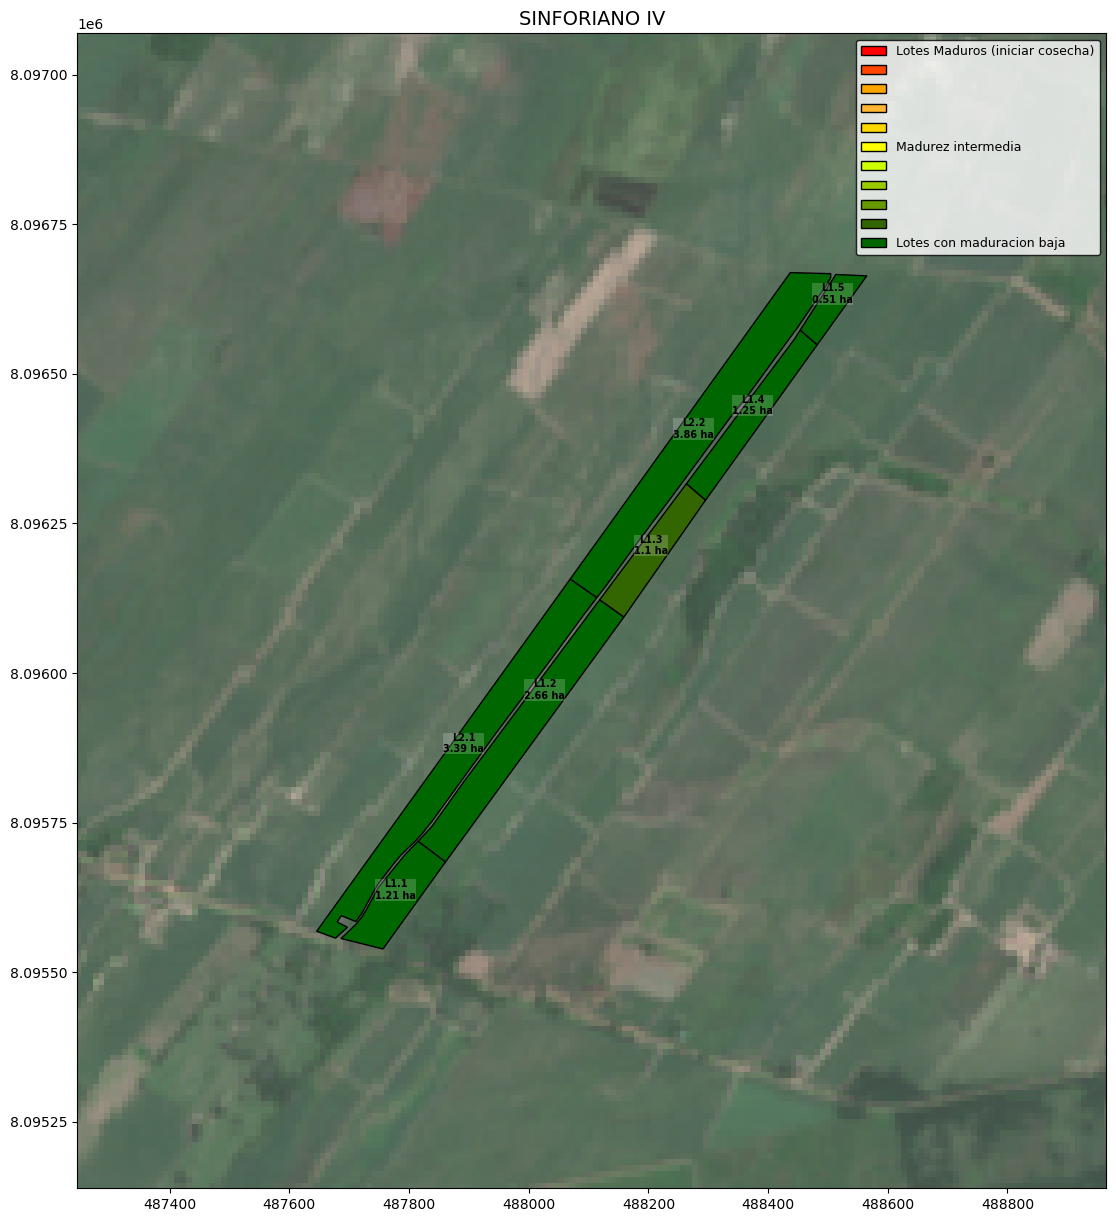

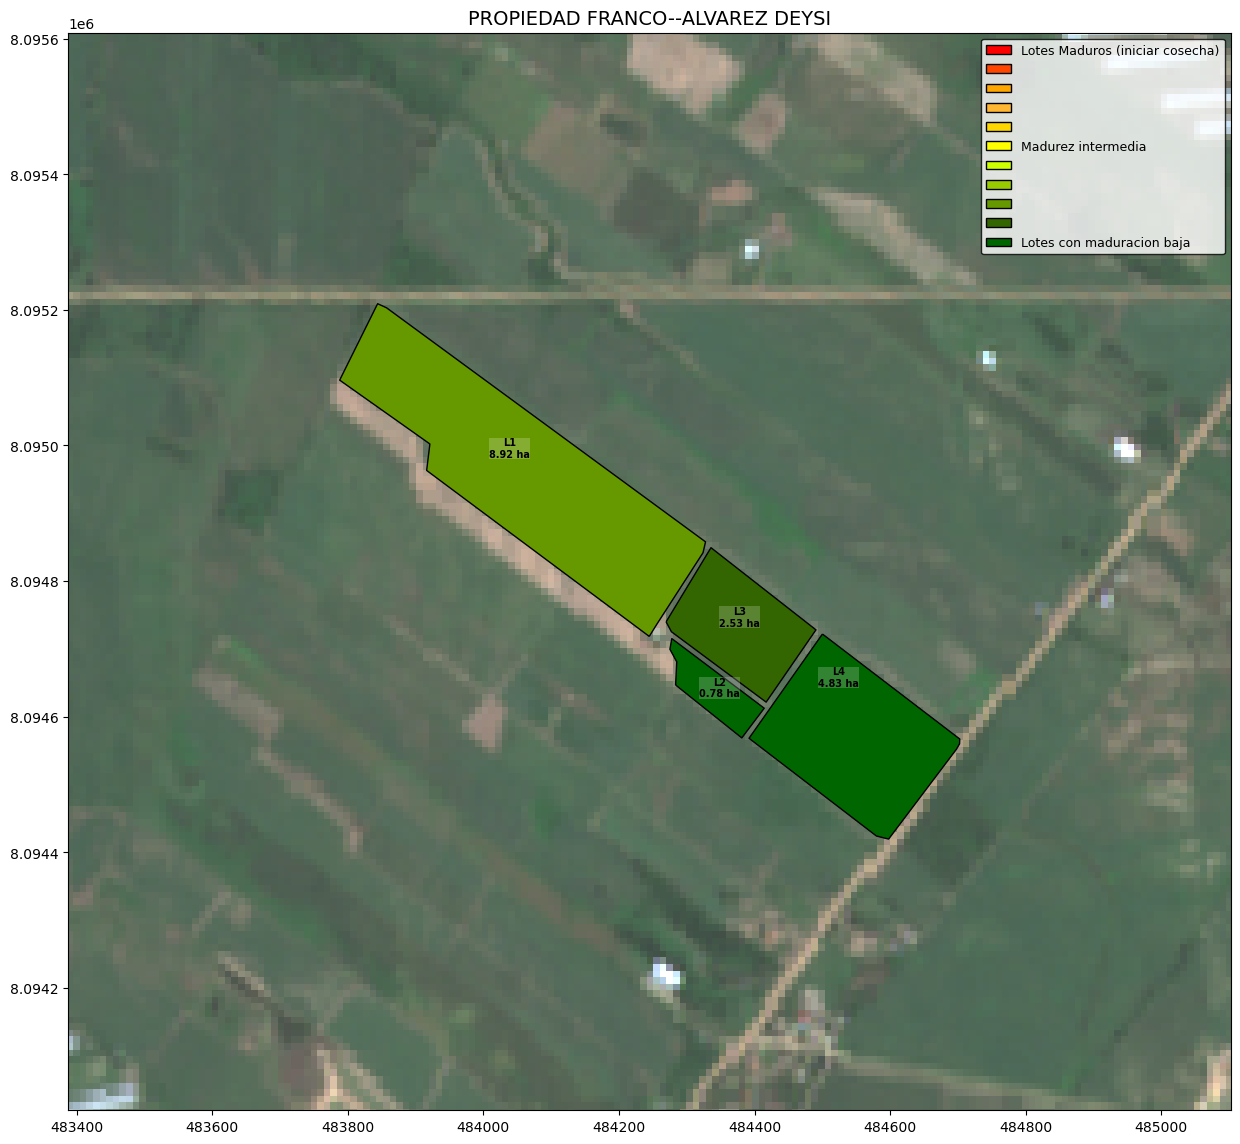

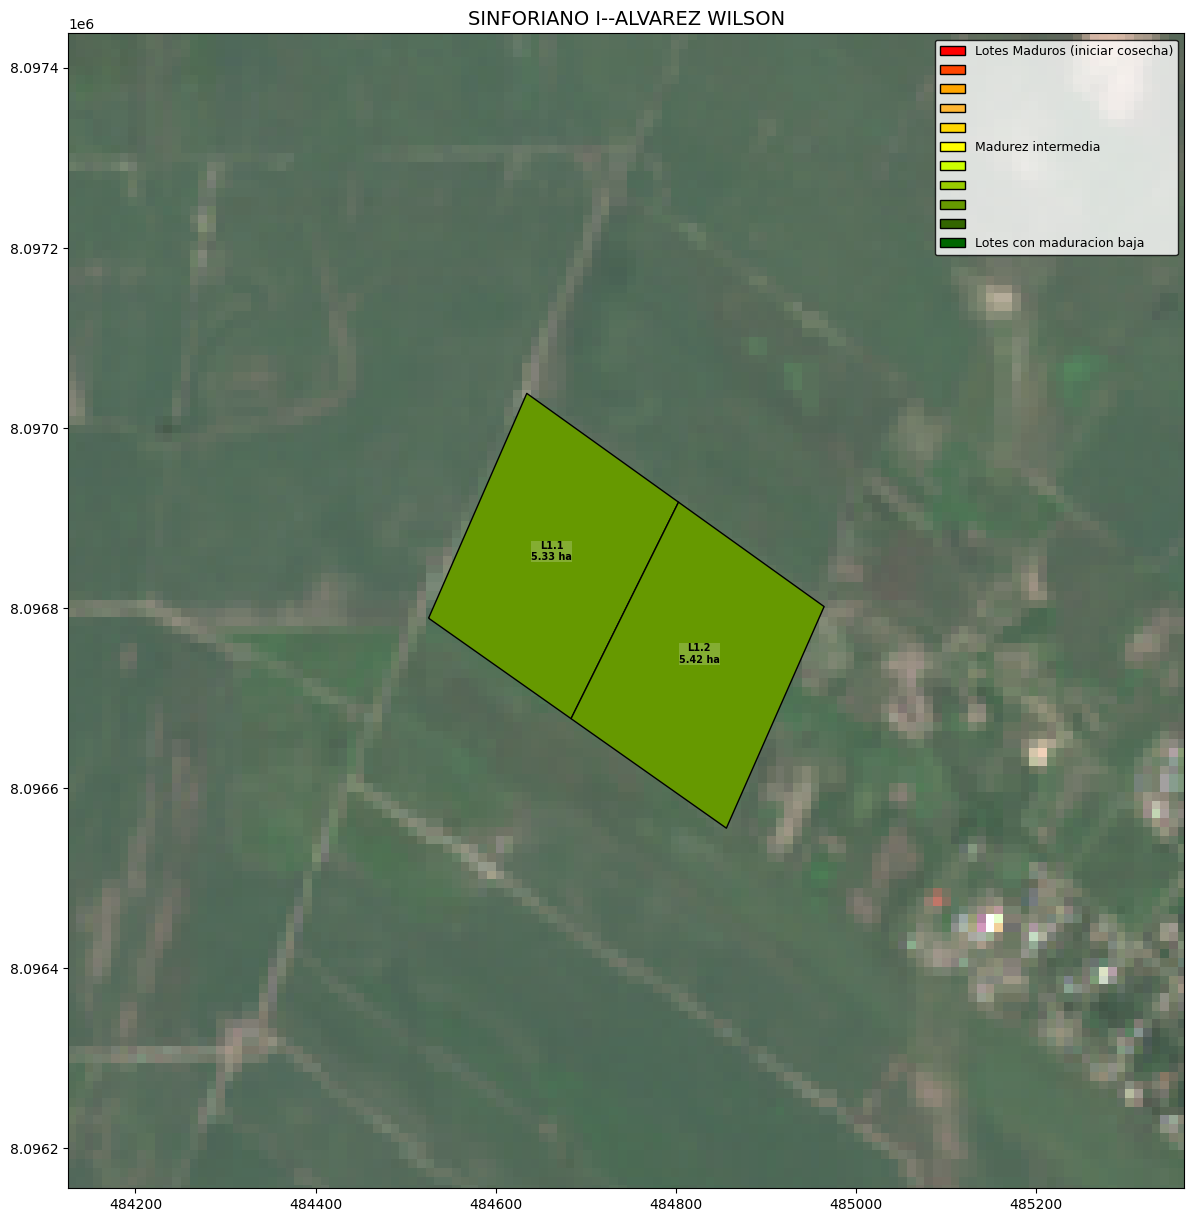

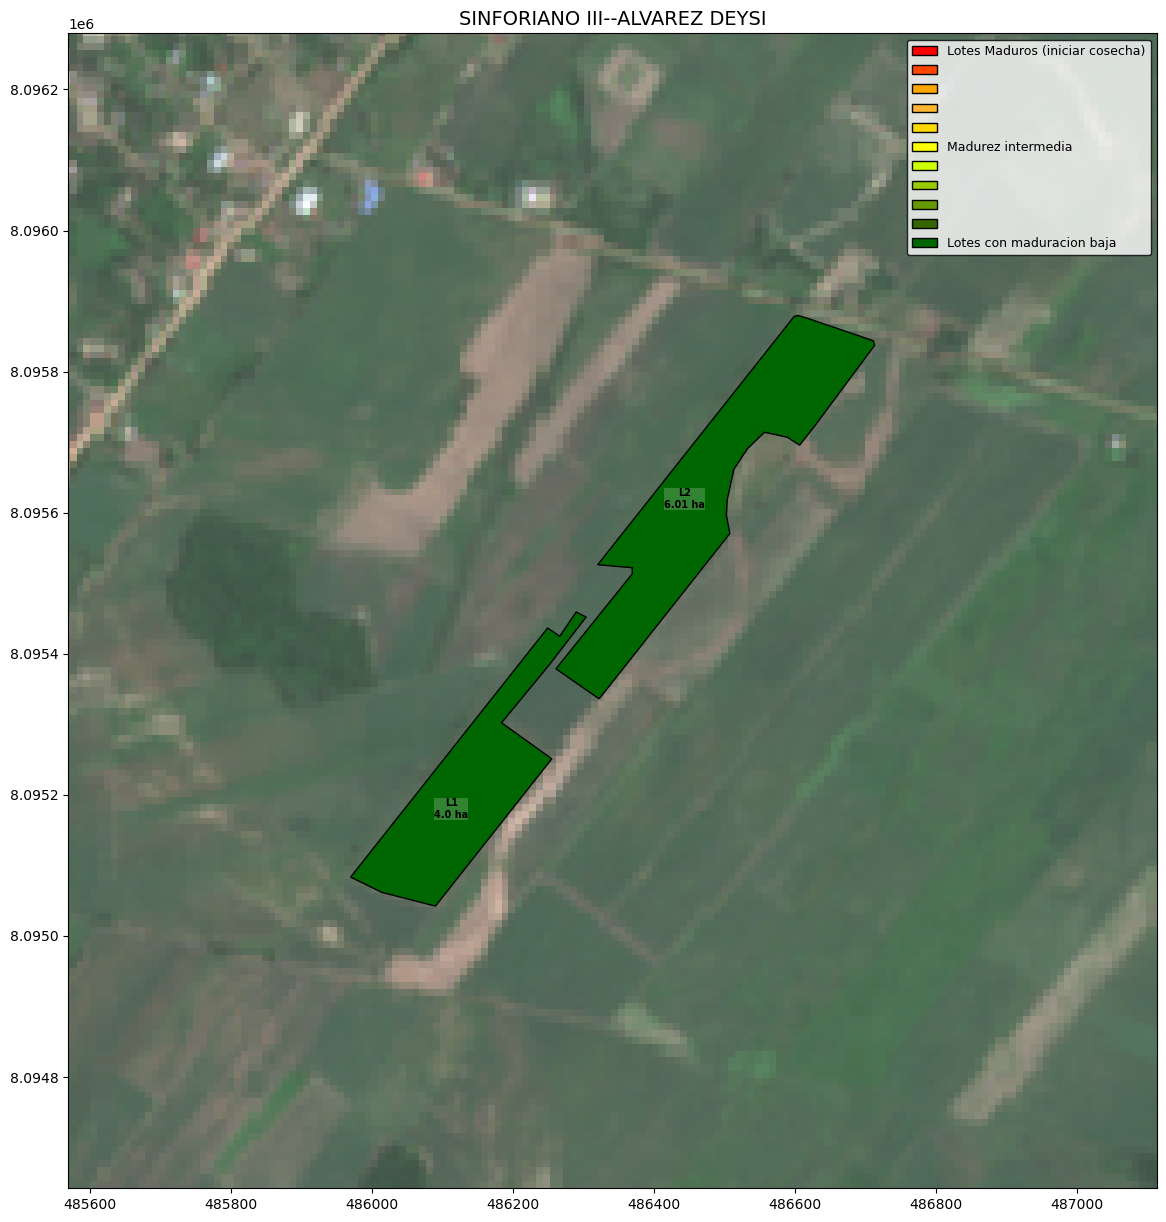

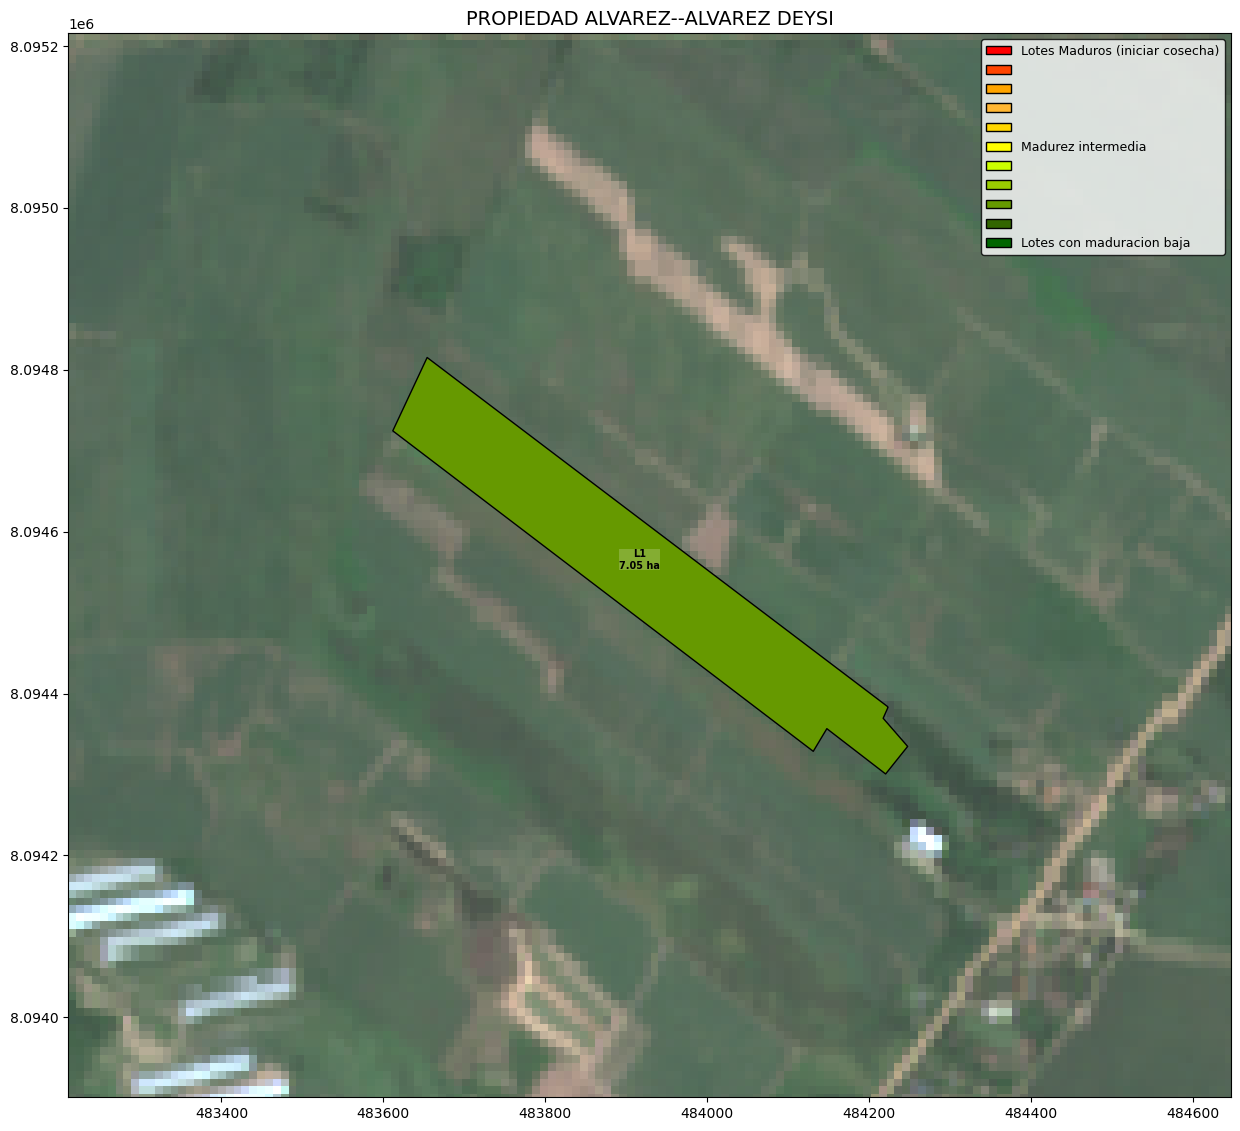

In [85]:
for i in props:
    prop = gdf_cat[gdf_cat['unidad_01'] == i]
    path_plano = os.path.join(RUTA_COMPLETA + "\planos")
    print(path_plano)
    generar_plano_os(prop, path_tif, path_plano)